In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [3]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [4]:
def pcX(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])
            fb[i][1][0]+=a*(z-ref)+b*(z-ref)**2/2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [106]:
mf_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.02",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"])))
e_co=mf_co.scf()
p_co=mf_co.make_rdm1()
mf_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.02",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"])))
e_nn=mf_nn.scf()
p_nn=mf_nn.make_rdm1()
#Cyanide ion
mf_cn=scf.RHF(gto.M(atom="C 0 0 0; N 0 0 2.02",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=-1))
e_cn=mf_cn.scf()
p_cn=mf_cn.make_rdm1()
#Nitronium
mf_on=scf.RHF(gto.M(atom="O 0 0 0; N 0 0 2.02",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=+1))
e_on=mf_on.scf()
p_on=mf_on.make_rdm1()

converged SCF energy = -112.713535796845
converged SCF energy = -108.917299271881
converged SCF energy = -92.2504473781489
converged SCF energy = -128.87963857573


In [80]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7,ref=7),"N2":pcX(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return e

In [97]:
def E_cn(l):
    mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7)},verbose=1)
    #mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return e

In [103]:
def E_on(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    #mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return e

In [81]:
def n_sap(zp):
    dl=.1
    Es_nc=np.asarray([E_nc(-3*dl),E_nc(-2*dl),E_nc(-dl),E_nc(0),E_nc(dl),E_nc(2*dl),E_nc(3*dl)])
    sap=[Es_nc[3]]
    inc=[]
    for i in range(6):
        inc.append(np.einsum('i,i',fds7[i+1],Es_nc)/dl**(i+1)/np.math.factorial(i+1)*zp**(i+1))
        sap.append(sap[i]+inc[-1])
    return sap

In [98]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,E(1)

(array([-108.91729927, -108.91729927, -112.73395605, -112.73395605,
        -112.68614669, -112.68614669, -112.74706077]), -112.71353579684612)

In [101]:
dl=.05
Es=np.asarray([E_cn(-3*dl),E_cn(-2*dl),E_cn(-dl),e_nn,E_cn(dl),E_cn(2*dl),E_cn(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_cn,apdft-e_cn

(array([-108.91729927,  -90.64332088,  -92.29055663,  -92.25104275,
         -92.25130948,  -92.2492709 ,  -92.24924551]),
 -92.25044737814876,
 array([-1.66668519e+01,  1.60712649e+00, -4.01092503e-02, -5.95369490e-04,
        -8.62097025e-04,  1.17647453e-03,  1.20187090e-03]))

In [107]:
dl=.05
Es=np.asarray([E_on(-3*dl),E_on(-2*dl),E_on(-dl),e_nn,E_on(dl),E_on(2*dl),E_on(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_on,apdft-e_on

(array([-108.91729927, -127.19127766, -128.83851341, -128.87802729,
        -128.87829401, -128.88033259, -128.88030738]),
 -128.87963857572998,
 array([ 1.99623393e+01,  1.68836092e+00,  4.11251705e-02,  1.61129009e-03,
         1.34456907e-03, -6.94012523e-04, -6.68799309e-04]))

In [89]:
e_cn,E_cn(1)

(-92.25044737814876, -92.25044737815016)

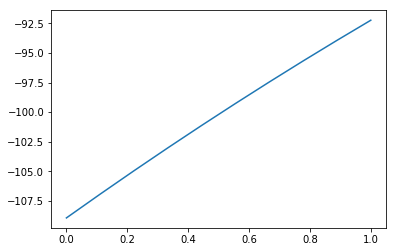

In [93]:
lins=np.linspace(0,1,10)
a=[]
for i in lins:
    a.append(E_cn(i))
plt.plot(lins,a)

In [83]:
apdft-np.array([-108.91659162, -108.91659162, -108.90670185, -108.90670185,\
        -108.86130095, -108.86130095, -108.92434908])-108.89005609416202+112.71614182671563

array([ 3.82537808e+00,  3.82537808e+00, -1.16846894e-03, -1.16846900e-03,
        1.23999678e-03,  1.23999738e-03,  3.37404317e-03])

In [84]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,E(1)

(array([-108.91729927, -108.91729927, -112.73395605, -112.73395605,
        -112.68614669, -112.68614669, -112.74706077]), -112.71353579684597)

In [64]:
n_c=np.asarray(n_c)
n_o=np.asarray(n_o)
-(n_o+n_c)+E_nc(1)+E_nc(-1)

array([-2.93330350e+00, -2.93330350e+00,  8.44934877e-02,  8.44934877e-02,
       -9.73410990e-03, -9.73411008e-03, -7.70103470e-04])

In [65]:
apdft,apdft-n_o-n_c+E_nc(1)+E_nc(-1),e_co

(array([-108.91659162, -108.91659162, -112.73562595, -112.73562595,
        -112.69210862, -112.69210862, -112.74427294]),
 array([-111.84989512, -111.84989512, -112.65113247, -112.65113247,
        -112.70184273, -112.70184273, -112.74504305]),
 -112.71614182671492)

Very important conclusion: the problem is due to transmutations on adjacent atoms, the serie for lonly atoms converges pretty well. The serie NN->CN- or NN->NO+ converges nice and smooth. <br> this might be a point for discussion.
Do they converge also for density???

In [132]:
def P_cn(l):
    mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7)},verbose=1)
    #mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    mf_l.conv_tol=1e-12
    mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return mf_l.make_rdm1()

In [134]:
def P_on(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.02",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    mf_l.conv_tol=1e-12
    mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return mf_l.make_rdm1()

In [133]:
dl=.1
Ps=np.asarray([P_cn(-3*dl),P_cn(-2*dl),P_cn(-dl),p_nn,P_cn(dl),P_cn(2*dl),P_cn(3*dl)])
apdft=[p_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,ijk->jk',fds7[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
for i in apdft:
    print(norm(i),norm(p_cn),norm(i-p_cn))

2.9151404666850684 3.066925242901826 1.2966486321548536
2.994131162933564 3.066925242901826 0.6421395797870044
3.175491064814114 3.066925242901826 0.5900823287061094
3.208430204500736 3.066925242901826 0.41207263417631784
3.1266426349815286 3.066925242901826 0.40019687232758455
3.021652339549074 3.066925242901826 0.2115770296119452
3.041140250555965 3.066925242901826 0.20011232330050735


In [135]:
dl=.1
Ps=np.asarray([P_on(-3*dl),P_on(-2*dl),P_on(-dl),p_nn,P_on(dl),P_on(2*dl),P_on(3*dl)])
apdft=[p_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,ijk->jk',fds7[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
for i in apdft:
    print(norm(i),norm(p_cn),norm(i-p_on))

2.9151404666850684 3.066925242901826 0.7088556109449528
3.272195121313862 3.066925242901826 0.6319305949707837
3.0989433843879812 3.066925242901826 0.36921035170896577
2.920507866312658 3.066925242901826 0.38174865475493713
3.040292192175051 3.066925242901826 0.23510360387154525
3.1071474058134867 3.066925242901826 0.24410413922244206
3.0246264002004244 3.066925242901826 0.10681855065868026


In [136]:
norm(P_on(1)-p_on)

3.0561559753901215e-06

There is also some convergence for density, though is a bit slower 